# Table of Contents
- [Introduction](#introduction)
    - [Load the data](#load-the-data)
    - [Plotting of the data](#plotting-of-the-data)
    - [Tokenizing the data](#tokenizing-the-data)
    - [Visualizing the tokens within the data](#visualizing-the-tokens-within-the-data)
    - [PCA analysis of the data](#pca-analysis-of-the-data)
    - [Model training and evaluation](#model-training-and-evaluation)
- [REFERENCES](#references)

# Introduction
This contains the code for section 1 Part 1 of the kaggle mini project. In here, I perform exploratory data analysis of the BBC data and create features out of the text in each article. The analysis is performed for the train data set.

## Load the data
This section of the code loads the data for the analysis

In [1]:
# import all libraries used in this code

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#load the training data
df_train = pd.read_csv("data/BBC News Train.csv")

#factorize the article categories in order to make the prediction a lot easier
df_train['category_id'] = df_train.Category.factorize()[0]

#keep a key dictionary of the factorize operation just in case
#filter the ids and categories to not have repetition
track_item = set()
id_list = [id for id in df_train.Category.factorize()[0] if id not in track_item and not track_item.add(id)]
track_cat = set()
cat_list = [cat for cat in df_train.Category.factorize()[1] if cat not in track_cat and not track_cat.add(cat)]
category_to_id = dict(zip(id_list, track_cat))

## Plotting of the data
Let's create some plots about the number of documents per class, and also do some initial data description stats

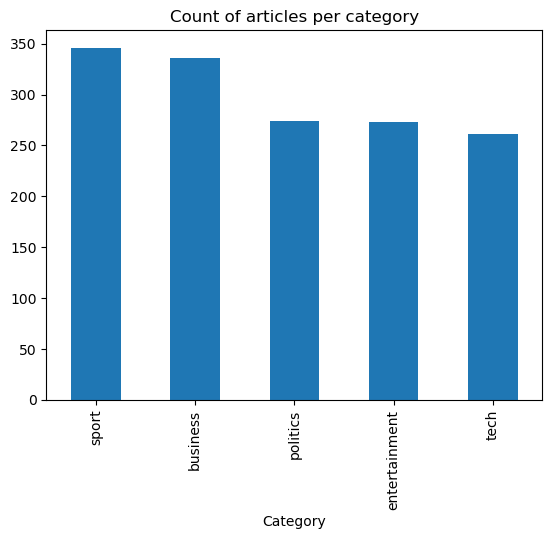

   ArticleId                                               Text  Category  \
0       1833  worldcom ex-boss launches defence lawyers defe...  business   
1        154  german business confidence slides german busin...  business   
2       1101  bbc poll indicates economic gloom citizens in ...  business   
3       1976  lifestyle  governs mobile choice  faster  bett...      tech   
4        917  enron bosses in $168m payout eighteen former e...  business   

   category_id  
0            0  
1            0  
2            0  
3            1  
4            0  


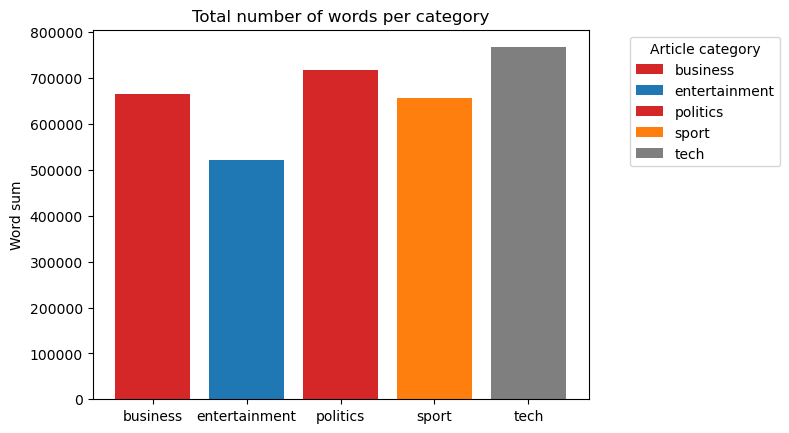

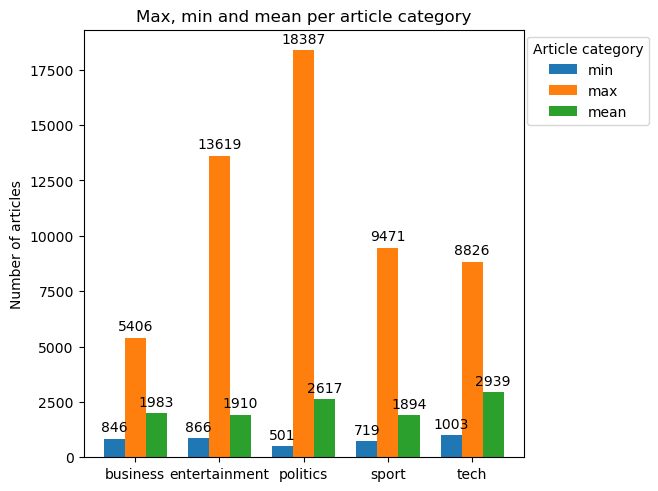

In [3]:
df_train.Category.value_counts().plot(kind='bar',title="Count of articles per category")
plt.show()

# lets also print the first 5 entries of the dataframe
print(df_train.head())

# do initial stats on the data: count the total number of words per category and then the min, mean, and max across the articles
df_train['Word_count'] = [len(article_words) for article_words in df_train.Text]

stats_to_plot = df_train.groupby(['Category', 'category_id'], as_index=False)['Word_count'].agg(['min', 'max', 'mean', 'sum'])
stats_to_plot['mean'] = np.floor(stats_to_plot['mean']).astype(int)

fig, ax = plt.subplots()
bar_labels = ['business', 'entertainment', 'politics', 'sport', 'tech']
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange', 'tab:gray']
ax.bar(stats_to_plot['Category'], stats_to_plot['sum'], label=bar_labels, color=bar_colors)
ax.set_ylabel('Word sum')
ax.set_title('Total number of words per category')
ax.legend(title='Article category', loc = 1, bbox_to_anchor = (1.4, 1))

keys = []
items = []
for key in stats_to_plot.columns:
    keys.append(key)
    items.append(list(stats_to_plot.loc[:, key]))
items_to_plot = dict(zip(keys, items))
data_to_plot  = items_to_plot.copy()

#Remove items we do not care about to make the plotting easier
iterable_keys = list(data_to_plot.keys())
for keys in iterable_keys:
    if keys in ['Category', 'category_id', 'sum']:
        data_to_plot.pop(keys, None)
    else:
        continue

x = np.arange(len(stats_to_plot['Category']))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in data_to_plot.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of articles')
ax.set_title('Max, min and mean per article category')
ax.set_xticks(x + width, items_to_plot['Category'])
ax.legend(title='Article category', loc = 1, bbox_to_anchor = (1.3, 1))
plt.show()




## Tokenizing the data
After doing some initial data analysis, we need to tokenize the words for each article to be able to meaningfully train an AI model on the data to make accurate predictions. Tne approach I use a *"bag of words"* model: for each article, the presence and frequency of words is taken into consideration, but the order in which they occur is ignored.

The model calculates *Term Frequency, Inverse Document Frequency*. This stat represents word importance in each document; the word frequency is used as a proxy for its importance, and document frequency (the number of documents containing a given word) as a measure of how common the word is, which minimizes the effect of stop-words. I leverage `TfidfVectonizer` from `sklearn` library for this, which calculates a tf-idf vector for each of the documents.

Also, the plan is to use the following parameters:
* `sublinear_tf = true` to use the log of the frequency--> this is because word frequency follows an exponential distribution
* normalize the vectors to `l2 norm` so that the length of the documents does not bias its representation
* consider bigrams using the feature `ngram_range` set to `(1,2)`. This will consider unigrams and bigrams in the analysis because these carry different meanings often in the context of articles
* `encoding = latin-1`
* `stop_words = "english"` to remove common pronouns and other common words that would be considered noisy features within the model

Initial model paramater that could be changed to evaluate model performance:
* `min_df = 3` to avoid rare words from affecting model performance

In [26]:
# code for tokenizing the data
# use utils to create class of data for train and test data
# tokenize the train data
import utils

df_train = pd.read_csv("data/BBC News Train.csv")
df_test = pd.read_csv("data/BBC News Test.csv")

#create the class

article_model = utils.Articles(df_train, df_test)

#encode the training labels
article_model.encode_labels('train')

#tokenize the data
summary = article_model.vectorize_words(article_model.factorized_train)

# print shape of the tokenized data
print(f'the tokenize method created a maxtrix of {article_model.word_tokens.shape[0]} articles and {article_model.word_tokens.shape[1]} features')

#visualize the tokenized data
print(summary.head())

the tokenize method created a maxtrix of 1490 articles and 19691 features
    00       000  000 2005  000 amicus  000 balloted  000 barrels  \
0  0.0  0.000000       0.0         0.0           0.0          0.0   
1  0.0  0.000000       0.0         0.0           0.0          0.0   
2  0.0  0.029767       0.0         0.0           0.0          0.0   
3  0.0  0.023129       0.0         0.0           0.0          0.0   
4  0.0  0.000000       0.0         0.0           0.0          0.0   

   000 business  000 cars  000 complaints  000 copies  ...  zinc  ziyi  \
0           0.0       0.0             0.0         0.0  ...   0.0   0.0   
1           0.0       0.0             0.0         0.0  ...   0.0   0.0   
2           0.0       0.0             0.0         0.0  ...   0.0   0.0   
3           0.0       0.0             0.0         0.0  ...   0.0   0.0   
4           0.0       0.0             0.0         0.0  ...   0.0   0.0   

   ziyi zhang  zombies  zone  zoom  zurich  zurich premiership  ca

## Visualizing the tokens within the data

We will use a horizontal bar plot to visualize the unigrams and bigrams with the highest scores from the TfidfVectorizer method and will use PCA to visualize if the data can be divided easily into 5 categories.

Text(0.5, 0, 'Influence')

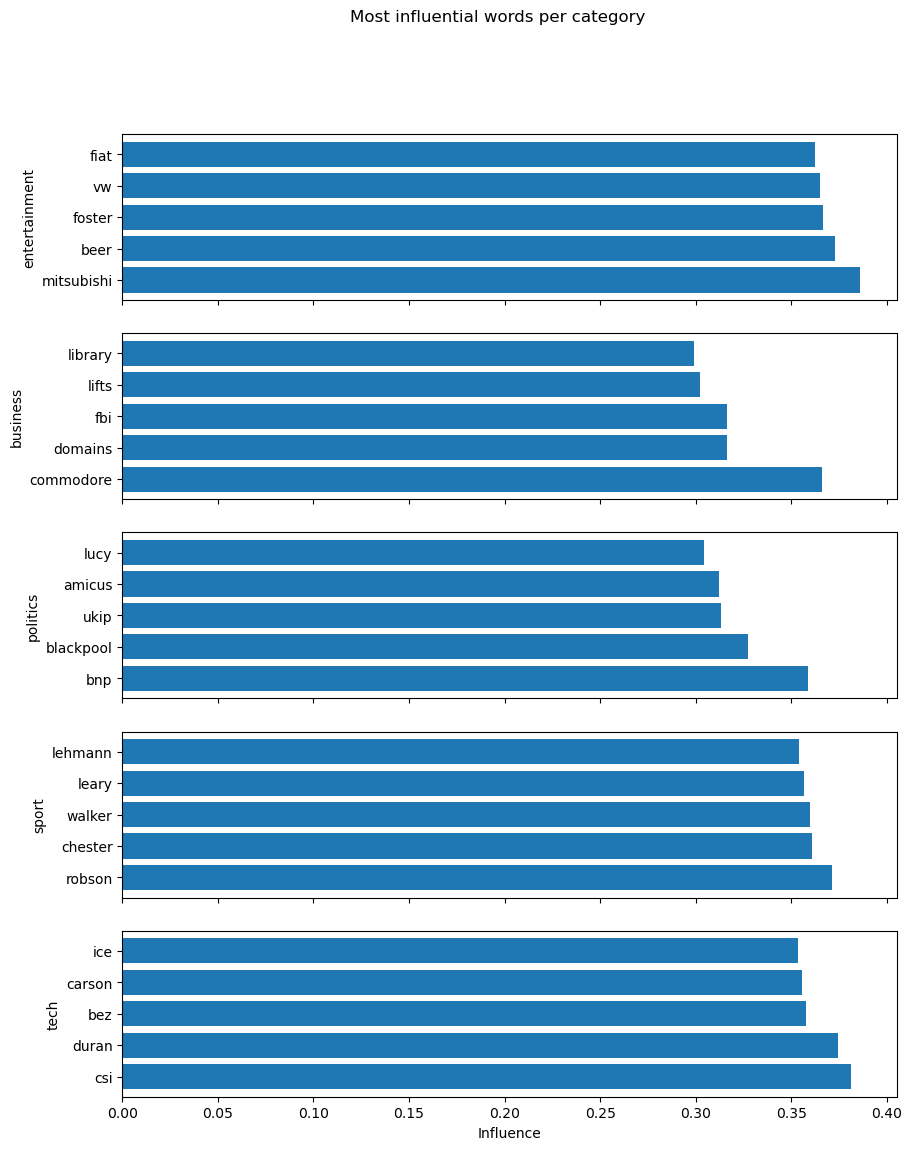

In [27]:
# get the 5 most influential tokens per category to plot them
# use dictionary of category to ID to plot the actual category and not the factorized ID
N = 5
token_scores = summary.drop(columns = ['ArticleId']).groupby(['category_id']).max()
top_words = {}
for cat_id, row in token_scores.iterrows():
    row_np = np.array(row)
    scores = []
    scores.append(row_np[np.argsort(row_np)[-N:]])
    scores.append(token_scores.columns[np.argsort(row_np)[-N:]])
    top_words[article_model.category_to_id[cat_id]] = scores


fig, ax = plt.subplots(len(top_words), figsize=(10, 2.5 * len(top_words)), sharex=True)
fig.suptitle('Most influential words per category')

for ax_instance, (category, (scores, words)) in zip(ax, top_words.items()):
    ax_instance.barh(words, scores)
    ax_instance.invert_yaxis()
    ax_instance.set_ylabel(category)
ax_instance.set_xlabel('Influence')

## PCA analysis of the data

The code below performs a PCA analysis of the data to determine if the features of the articles( as determined by tokenizing the words of each articles) can be grouped in the assumed 5 different categories. I will use PCA in order to confirm that the feature space being used (tokenizing the articles for each category) is representative enough for the task to be solvable. Given that we are dealing with language, correlations between the features are expected to be non-linear, so I will use `Kernel PCA`: Self-organizing maps and auto-encoders; however, for this case, I will only evaluate a subset of the data due to the high computational cost of this method and inability to analyze sparse matrices. I will also perform `Truncated SVD` with all of the data, which is more computational efficient, but it is better suited for features that are linearly correlated. This will allow me to compare the results.

From looking at both PCA analysis, we can conclude that it would be possible to predict if the data can be grouped into one of 5 different categories since the PCA analyses clearly show 5 main clusters. However, the `Kernel PCA` results look more seperable, as expected, since the features of the data (word toklens) are not linearly related.

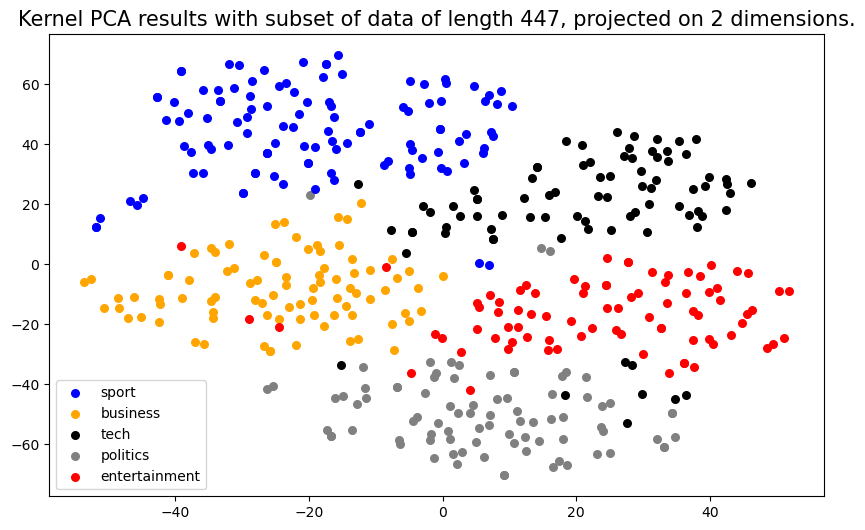

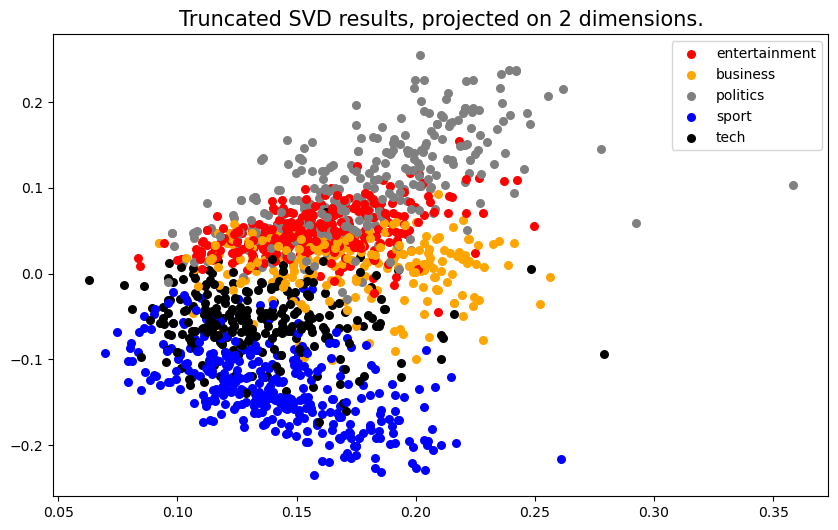

In [108]:
# doing Kernel PCA to see if there are at least 5 different clusters in which the data can be grouped on
from sklearn.manifold import TSNE

# Get raw summary data without columns that would influence model
summary_PCA = summary.drop(['category_id', 'ArticleId'], axis=1).copy()
# sample only a subset of the data because t-SNE is computationally expensive; analyze only 30% of the training samples
sample_size_PCA = int(len(summary_PCA) * 0.3)
# create a random subset of size sample_size_PCA from the tokenized data to analyze
np.random.seed(55)
sample_index_PCA = np.random.choice(range(len(summary_PCA)), size=sample_size_PCA)

# Perform the Kernel PCA analysis of the data
kernel_PCA_model = TSNE(n_components=2, learning_rate='auto', random_state=0).fit_transform(np.array(summary_PCA.iloc[sample_index_PCA,:]))

# Plot the embedded feature space
#create set for storing labels so that they do not get repeated
label_set = set()

# create figure and colors for the legend
colors = ['red', 'orange', 'gray', 'blue', 'black']
plt.figure(figsize=(10, 6))

#loop to create the scatter plot
for idx, sample  in enumerate(summary.iloc[sample_index_PCA,:]['category_id']):
    # get the points to plot in the iteration
    points = kernel_PCA_model[idx]
    # get the labels of the points
    label = article_model.category_to_id[sample]
    # if label has not been seen, add it; otherwise plot the point but skip the label
    if label not in label_set:
        plt.scatter(points[0], points[1], s=30, c=colors[sample], label=label)
        label_set.add(label)
    else:
        plt.scatter(points[0], points[1], s=30, c=colors[sample])

# Add title and legends to the plot
plt.title(f"Kernel PCA results with subset of data of length {sample_size_PCA}, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

# perform Truncated SVD with all of the data
from sklearn.decomposition import TruncatedSVD

# create the PCA model and do dimensionality reduction on the original raw data return from the vectorization of the class
truncated_PCA_model = TruncatedSVD(n_components=2, random_state=42).fit_transform(article_model.word_tokens)

# Plot the embedded feature space
#create set for storing labels so that they do not get repeated
label_set = set()

# create figure and colors for the legend
colors = ['red', 'orange', 'gray', 'blue', 'black']
plt.figure(figsize=(10, 6))

#loop to create the scatter plot
for idx, sample  in enumerate(summary['category_id']):
    # get the points to plot in the iteration
    points = truncated_PCA_model[idx]
    # get the labels of the points
    label = article_model.category_to_id[sample]
    # if label has not been seen, add it; otherwise plot the point but skip the label
    if label not in label_set:
        plt.scatter(points[0], points[1], s=30, c=colors[sample], label=label)
        label_set.add(label)
    else:
        plt.scatter(points[0], points[1], s=30, c=colors[sample])

# Add title and legends to the plot
plt.title(f"Truncated SVD results, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

## Model training and evaluation

In this section of the document, I will perform training and evaluation of a NMF model and a supervised learning model and compare their respective performances on the test data.

In [28]:
# code for tokenizing the data
# use utils to create class of data for train and test data
# tokenize the train data
df_train = pd.read_csv("data/BBC News Train.csv")
df_test = pd.read_csv("data/BBC News Test.csv")
import utils
example = utils.Articles(df_train, df_test)
example.encode_labels('train')
example.vectorize_words(example.factorized_train)



,00,000,000 2005,000 amicus,000 balloted,000 barrels,000 business,000 cars,000 complaints,000 copies,...,zinc,ziyi,ziyi zhang,zombies,zone,zoom,zurich,zurich premiership,category_id,ArticleId
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1833
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,154
2,0.0,0.029767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1101
3,0.0,0.023129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1976
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0.0,0.039584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,857
1486,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,325
1487,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1590
1488,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1587


**REFERENCES:**
* https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification: used this document as a guidance for the steps I should take during this exercise